In [1]:
! pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.5 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is inc

In [2]:
import cv2
import mediapipe as mp
import pandas as pd
import os

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Px4Vm3w11i0evtzxVIn7")
project = rf.workspace("duyguj").project("american-sign-language-letters-vouo0")
version = project.version(1)
dataset = version.download("multiclass")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.5 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to American-Sign-Language-Letters-1 in multiclass:: 100%|██████████| 1214/1214 [00:00<00:00, 7902.60it/s]


In [4]:
train_dir='/kaggle/working/American-Sign-Language-Letters-1/train'
train_csv=pd.read_csv('/kaggle/working/American-Sign-Language-Letters-1/train/_classes.csv')

valid_dir='/kaggle/working/American-Sign-Language-Letters-1/valid'
valid_csv=pd.read_csv('/kaggle/working/American-Sign-Language-Letters-1/valid/_classes.csv')

In [5]:
draw=mp.solutions.drawing_utils # to draw landmarks on image
hand=mp.solutions.hands #  model
my_hand=mp.solutions.hands.Hands()

In [6]:
import numpy as np

train_labels=train_csv.drop(['filename'],axis=1)
train_labels = np.argmax(train_labels.values, axis=1) # convert Y from one_hot encoding to label encoding 

valid_labels=valid_csv.drop(['filename'],axis=1)
valid_labels = np.argmax(valid_labels.values, axis=1) # from multiple columns to one column

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
train_data=pd.DataFrame()
valid_data=pd.DataFrame()

y_train=[]
y_valid=[]

**take hand points for every picture and store it in csv file**

In [8]:
def read_data(csv_file,directory,labels,X,Y,i=0):
    for filename in csv_file['filename']:
        image=cv2.imread(os.path.join(directory,filename))

        if image is None:
            print(f"Failed to load {filename}")
            continue

        image=cv2.resize(image,(224,224))
        height,width,_=image.shape # get size from image bec. may be write a value is not accessible 


        rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        rgb_image.flags.writeable=False # not do any operation on image through pose estimation process
        results = my_hand.process(rgb_image)
        rgb_image.flags.writeable=True

        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks: # hand_handmark------>Contains all the landmarks (21 key points) for a single hand, but it's not directly accessible 
                draw.draw_landmarks(rgb_image,hand_landmark,hand.HAND_CONNECTIONS)
                # rescale the points on the image size
                x = [ int(points.x*width) for points in hand_landmark.landmark] #hand_landmark.landmark-------->gives a list of Landmark objects, which contain the x, y, and z for each point.
                y = [ int(points.y*height) for points in hand_landmark.landmark]
                x_df = pd.DataFrame(x)
                y_df = pd.DataFrame(y)

            data=pd.concat([y_df, x_df], axis=0, ignore_index=True) # merge the values of x and y in same row
            X = pd.concat([X,data.T], axis=0, ignore_index=True) # add new raw to final dataframe(X)
            Y.append(labels[i])
        i+=1 
    return X,Y

W0000 00:00:1734536537.242814     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


**Apply the function on train_data**

In [9]:
X=pd.DataFrame()
Y=[]
train_data,y_train=read_data(train_csv,train_dir,train_labels,X,Y)

W0000 00:00:1734536537.276510     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734536537.314773     111 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


**Apply the function on valid data**

In [10]:
X=pd.DataFrame()
Y=[]
valid_data,y_valid=read_data(valid_csv,valid_dir,valid_labels,X,Y)

In [11]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,202,175,146,121,104,126,106,92,81,138,...,88,79,105,121,100,89,111,126,110,99
1,125,125,117,110,102,95,79,68,57,90,...,103,104,111,121,128,133,119,127,125,123
2,199,186,167,151,145,136,118,125,135,135,...,83,76,77,65,56,49,62,47,35,26
3,167,140,116,99,99,92,81,97,96,92,...,109,100,75,90,94,85,60,74,79,74
4,143,136,119,101,88,91,71,73,79,88,...,81,71,120,97,84,79,115,98,85,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,151,146,130,116,100,97,76,81,90,94,...,97,103,79,89,96,100,83,96,99,101
882,162,154,134,116,109,97,94,109,118,96,...,122,128,163,144,137,140,174,174,179,186
883,158,142,123,109,101,100,70,49,32,96,...,102,101,84,86,87,87,75,74,74,74
884,175,169,155,144,142,124,118,136,146,132,...,91,98,98,80,84,92,86,69,68,69


In [12]:
# check if there ia nulls values or not
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       886 non-null    int64
 1   1       886 non-null    int64
 2   2       886 non-null    int64
 3   3       886 non-null    int64
 4   4       886 non-null    int64
 5   5       886 non-null    int64
 6   6       886 non-null    int64
 7   7       886 non-null    int64
 8   8       886 non-null    int64
 9   9       886 non-null    int64
 10  10      886 non-null    int64
 11  11      886 non-null    int64
 12  12      886 non-null    int64
 13  13      886 non-null    int64
 14  14      886 non-null    int64
 15  15      886 non-null    int64
 16  16      886 non-null    int64
 17  17      886 non-null    int64
 18  18      886 non-null    int64
 19  19      886 non-null    int64
 20  20      886 non-null    int64
 21  21      886 non-null    int64
 22  22      886 non-null    int64
 23  23      886 non

In [13]:
y_train=pd.DataFrame(y_train)
y_valid=pd.DataFrame(y_valid)

In [14]:
print("Shape of merged_data:", train_data.shape)
print("Shape of y_labels:", y_train.shape)

Shape of merged_data: (886, 42)
Shape of y_labels: (886, 1)


In [15]:
# convert dataframe has one column to 1D 
y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()

**Normalize the data**

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(valid_data)

# **MLPClassifier using grid search**

In [17]:
param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128), (512, 256)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score


grid_search = GridSearchCV(MLPClassifier(max_iter=300, random_state=42), param_grid, cv=3)
grid_search.fit(train_data_scaled, y_train)

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=300, random_state=42),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(128, 64), (256, 128),
                                                (512, 256)],
                         'learning_rate_init': [0.001, 0.01]})

In [19]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(val_data_scaled)

In [20]:
from sklearn.metrics import accuracy_score

y_pred = best_mlp.predict(val_data_scaled)
accuracy = accuracy_score(y_valid, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 70.31%


In [21]:
train_accuracy = []
val_accuracy = []

for i in range(1, 300):
    best_mlp.max_iter = i
    best_mlp.fit(train_data_scaled, y_train)
    train_accuracy.append(best_mlp.score(train_data_scaled, y_train))
    val_accuracy.append(best_mlp.score(val_data_scaled, y_valid))



Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iteration

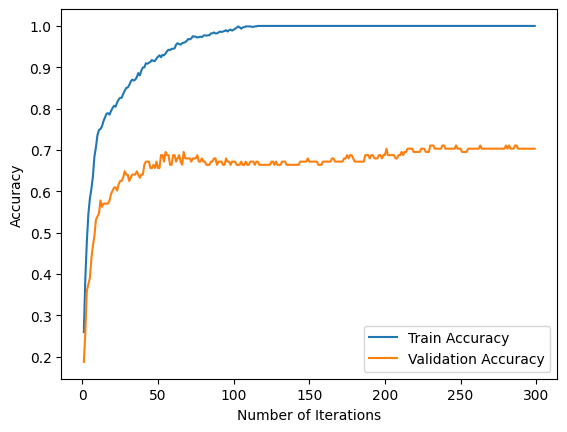

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(1, 300), train_accuracy, label="Train Accuracy")
plt.plot(range(1, 300), val_accuracy, label="Validation Accuracy")
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Random forest**

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train_data_scaled, y_train)

RandomForestClassifier(random_state=0)

In [24]:
y_pred = model.predict(val_data_scaled)

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)
class_report = classification_report(y_valid, y_pred)

In [26]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.5625


In [27]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 7 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0]
 [1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 1 0 0 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 5 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 5 0 0

In [28]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       1.00      0.78      0.88         9
           2       0.25      0.50      0.33         2
           3       0.62      1.00      0.77         5
           4       0.33      0.50      0.40         4
           5       0.80      1.00      0.89         8
           6       0.33      0.20      0.25         5
           7       1.00      0.17      0.29         6
           8       0.00      0.00      0.00         1
           9       0.50      0.50      0.50         4
          10       1.00      0.50      0.67         6
          11       1.00      0.50      0.67         4
          12       0.50      0.25      0.33         8
          13       0.00      0.00      0.00         1
          14       0.83      0.71      0.77         7
          15       0.57      0.80      0.67         5
          16       0.50      1.00      0.67         4
    